In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Fri Mar 22 18:32:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              43W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install scikit-ntk

In [ ]:
import tensorflow as tfa
import keras
from keras.layers import Dense,Flatten,MaxPool2D,Conv2D,Dropout,Activation,BatchNormalization
from keras.models import Sequential
from skntk import NeuralTangentKernel as NTK
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.signal as tf
print("all the libraries are imported")

all the libraries are imported


In [ ]:
dataset_dir=r'/content/drive/MyDrive/the dataset/dataset copy/Copy of data'
image_height=512
image_width=512
batch_size=32
seed=42
validation_split=0.1

In [ ]:
train=keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    batch_size=batch_size,
    label_mode='int',
    image_size=(image_height,image_width),
    seed=seed,
    validation_split=validation_split,
    subset='training'
)
test=keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(image_height,image_width),
    seed=seed,
    validation_split=validation_split,
    subset='validation'
)

Found 1564 files belonging to 2 classes.
Using 1408 files for training.
Found 1564 files belonging to 2 classes.
Using 156 files for validation.


In [ ]:
input_shape=(image_height,image_width,3)

In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
resize_rescale=keras.Sequential([
    keras.layers.Resizing(image_height,image_width),
    keras.layers.Rescaling(1./255)
])

In [ ]:
data_augmentation=keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
])

In [ ]:
with tf.device('/GPU:0'):
  def fourier(inp=None):
    if inp==None:
        pass
    elif(inp!=None):
        return tf.fft3d(inp)
  def ntk(inp=None):
    if(inp==None):
        pass
    elif(inp!=None):
        n = NTK(depth=3, bias=0.01, bias_bounds=(1e-5, 1e5))
        return n
  model=Sequential([
      resize_rescale,
      data_augmentation,
      Conv2D(64,(2,2),padding='same',input_shape=input_shape),
      Activation(ntk()),
      MaxPool2D(pool_size=(2,2)),

      Conv2D(64,(2,2),padding='same'),
      Activation(ntk()),
      MaxPool2D(pool_size=(2,2)),

      Conv2D(64,(2,2),padding='same'),
      Activation(ntk()),
      MaxPool2D(pool_size=(2,2)),

      Conv2D(64,(2,2),padding="same"),
      Activation(ntk()),
      MaxPool2D(pool_size=(2,2)),
      Dropout(0.2),


      Flatten(),

      Dense(128),
      Activation(fourier()),

      Dense(1),
      Activation('sigmoid')
    ])
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  history=model.fit(train,epochs=150,batch_size=32)

Epoch 1/150
44/44 [==============================] - 195s 3s/step - loss: 1.1216 - accuracy: 0.6726
Epoch 2/150
44/44 [==============================] - 5s 110ms/step - loss: 0.5056 - accuracy: 0.7699
Epoch 3/150
44/44 [==============================] - 5s 110ms/step - loss: 0.5122 - accuracy: 0.7564
Epoch 4/150
44/44 [==============================] - 5s 110ms/step - loss: 0.5003 - accuracy: 0.7869
Epoch 5/150
44/44 [==============================] - 5s 111ms/step - loss: 0.5028 - accuracy: 0.7770
Epoch 6/150
44/44 [==============================] - 5s 110ms/step - loss: 0.4601 - accuracy: 0.8168
Epoch 7/150
44/44 [==============================] - 5s 110ms/step - loss: 0.4097 - accuracy: 0.8331
Epoch 8/150
44/44 [==============================] - 5s 111ms/step - loss: 0.4226 - accuracy: 0.8260
Epoch 9/150
44/44 [==============================] - 5s 111ms/step - loss: 0.4238 - accuracy: 0.8246
Epoch 10/150
44/44 [==============================] - 5s 110ms/step - loss: 0.3990 - accurac

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 512, 512, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 64)      832       
                                                                 
 activation (Activation)     (None, 512, 512, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 256, 256, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      16448     
                                                      

In [ ]:
accuracy=model.evaluate(test)
print(accuracy)

5/5 [==============================] - 18s 240ms/step - loss: 0.1229 - accuracy: 0.9423
[0.12294435501098633, 0.942307710647583]


In [ ]:
amcuracy=model.evaluate(train)
print(amcuracy)

44/44 [==============================] - 3s 48ms/step - loss: 0.1444 - accuracy: 0.9418
[0.14439423382282257, 0.9417613744735718]


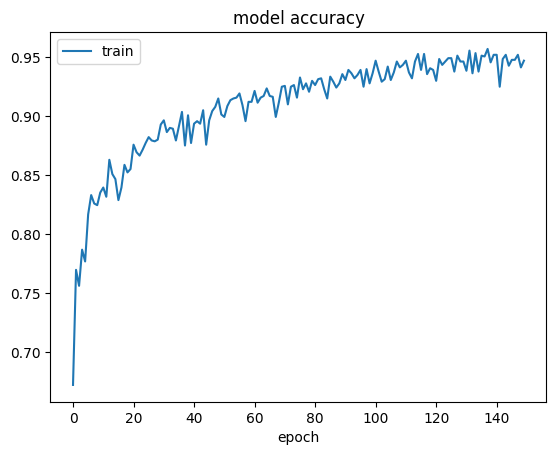

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()